In [3]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
import torchvision
from tqdm.auto import tqdm

In [5]:
df = pd.read_csv('/content/drive/MyDrive/kannada/train.csv/train.csv')
df.tail()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
59995,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59998,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59999,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train= pd.read_csv('/content/drive/MyDrive/kannada/train.csv/train.csv')
test_df= pd.read_csv('/content/drive/MyDrive/kannada/test.csv/test.csv')
val = pd.read_csv('/content/drive/MyDrive/kannada/Dig-MNIST.csv/Dig-MNIST.csv')

In [7]:
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset

class KannadaDataset(Dataset):

  def __init__(self, data, transform= None, train= True):

    if train == True:
        self.labels = data['label']
        self.data = data.drop('label', axis= 1)
        self.transform = transform
    else:
        self.data = data
        self.transform = transform


  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    image = torch.tensor(self.data.iloc[idx, :])

    label = self.labels.iloc[idx]

    if self.transform:
      image = self.transform(image)

    return image, label

In [8]:
train = KannadaDataset(df, train= True)
val = KannadaDataset(val, train= True)

In [9]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train, batch_size= 64, shuffle= True)
val_dataloader = DataLoader(val, batch_size= 64, shuffle= True)

tensor([9])


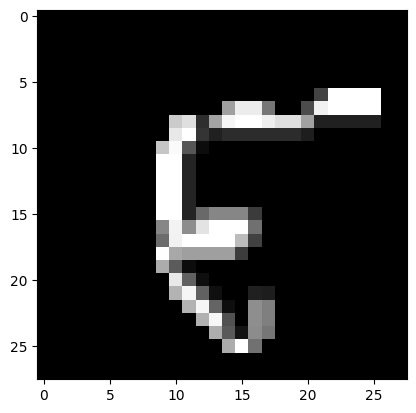

In [10]:
import matplotlib.pyplot as plt
images, labels = next(iter(train_dataloader))
images, labels = images[:1].reshape(28,28), labels[:1]

plt.imshow(torchvision.utils.make_grid(images)[0,:,:], cmap= "gray")
print(labels)

In [11]:
class KDNet(nn.Module):

  def __init__(self):
    super(KDNet, self).__init__()
    self.fc1 = nn.Linear(28 * 28, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 128)
    self.fc4 = nn.Linear(128, 64)
    self.fc5 = nn.Linear(64, 10)


  def forward(self, x):
    x = F.relu(self.fc1(x.float()))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.relu(self.fc4(x))
    x = F.softmax(self.fc5(x),dim = 1)

    return x

In [12]:
class KDNetBN(nn.Module):

  def __init__(self):
    super(KDNetBN, self).__init__()
    self.fc1 = nn.Linear(28 * 28, 512)
    self.bn1 = nn.BatchNorm1d(512)
    self.fc2 = nn.Linear(512, 256)
    self.bn2 = nn.BatchNorm1d(256)
    self.fc3 = nn.Linear(256, 128)
    self.bn3 = nn.BatchNorm1d(128)
    self.fc4 = nn.Linear(128, 64)
    self.bn4 = nn.BatchNorm1d(64)
    self.fc5 = nn.Linear(64, 10)


  def forward(self, x):
    x = x.float()

    x = self.fc1(x)
    x = self.bn1(x)
    x = F.relu(x)

    x = self.fc2(x)
    x = self.bn2(x)
    x = F.relu(x)

    x = self.fc3(x)
    x = self.bn3(x)
    x = F.relu(x)

    x = self.fc4(x)
    x = self.bn4(x)
    x = F.relu(x)

    x = self.fc5(x)
    x = F.softmax(x, dim= 1)

    return x

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [14]:
model = KDNet().to(device)
model1 = KDNetBN().to(device)


## Training the model

In [15]:
from sklearn.metrics import accuracy_score

def train_model(model, dataloader, optmizer, loss_fn):
    model.train()
    train_loss, train_acc= 0, 0

    for X, y in dataloader:
        # Forward Pass
        X, y = X.to(torch.device("cuda")), y.to(torch.device("cuda"))
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        train_loss += loss
        train_acc += accuracy_score(y.cpu(), y_pred.cpu().argmax(dim= 1))

        # Back Propagation
        optmizer.zero_grad()
        loss.backward()
        optmizer.step()

        train_loss /= len(dataloader)

    train_acc /= len(dataloader)
    print(f"Train loss: {train_loss:.4f} | Train accuracy: {train_acc:.4f}")

    return train_loss, train_acc

In [16]:
def val_model(model, dataloader, optmizer, loss_fn):
  model.eval()
  val_loss, val_acc= 0, 0

  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      y_pred = model(X)

      val_loss += loss_fn(y_pred, y)
      val_acc += accuracy_score(y.cpu(), y_pred.cpu().argmax(dim= 1))

      val_loss /= len(dataloader)

  val_acc /= len(dataloader)
  print(f"Val loss: {val_loss:.4f} | Val accuracy: {val_acc:.4f}")

  return val_loss, val_acc

In [17]:
lr = 1e-4
loss_fn = nn.CrossEntropyLoss()
optmizer= torch.optim.Adam(model.parameters(), lr= lr)
optmizer1= torch.optim.Adam(model1.parameters(), lr= lr)
num_epochs = 10

In [18]:
torch.manual_seed(0)

train_loss_wobn = []
train_acc_wobn = []
val_loss_wobn = []
val_acc_wobn = []
train_loss_wbn = []
train_acc_wbn = []
val_loss_wbn = []
val_acc_wbn = []

for epoch in tqdm(range(num_epochs)):

    print("--------------------------------------------------------")

    print(f"Epoch {epoch + 1}/{num_epochs}")

    print("Model 1 ")
    x1 = train_model(model, train_dataloader, optmizer, loss_fn)
    train_loss_wobn.append(x1[0])
    train_acc_wobn.append(x1[1])
    x2 = val_model(model, val_dataloader, optmizer, loss_fn)
    val_loss_wobn.append(x2[0])
    val_acc_wobn.append(x2[1])

    print("Model 2 ")
    x3 = train_model(model1, train_dataloader, optmizer1, loss_fn)
    train_loss_wbn.append(x3[0])
    train_acc_wbn.append(x3[1])
    x4 = val_model(model1, val_dataloader, optmizer1, loss_fn)
    val_loss_wbn.append(x4[0])
    val_acc_wbn.append(x4[1])

    print("--------------------------------------------------------")

  0%|          | 0/10 [00:00<?, ?it/s]

--------------------------------------------------------
Epoch 1/10
Model 1 
Train loss: 0.0016 | Train accuracy: 0.9324
Val loss: 0.0113 | Val accuracy: 0.6212
Model 2 
Train loss: 0.0016 | Train accuracy: 0.8912
Val loss: 0.0114 | Val accuracy: 0.6246
--------------------------------------------------------
--------------------------------------------------------
Epoch 2/10
Model 1 
Train loss: 0.0016 | Train accuracy: 0.9770
Val loss: 0.0121 | Val accuracy: 0.6083
Model 2 
Train loss: 0.0016 | Train accuracy: 0.9778
Val loss: 0.0115 | Val accuracy: 0.6524
--------------------------------------------------------
--------------------------------------------------------
Epoch 3/10
Model 1 
Train loss: 0.0016 | Train accuracy: 0.9832
Val loss: 0.0111 | Val accuracy: 0.6558
Model 2 
Train loss: 0.0016 | Train accuracy: 0.9858
Val loss: 0.0114 | Val accuracy: 0.6665
--------------------------------------------------------
--------------------------------------------------------
Epoch 4/10

In [21]:
train_loss_wobn_np = [item.detach().cpu().numpy() for item in train_loss_wobn]
train_acc_wobn_np = [item for item in train_acc_wobn]
val_loss_wobn_np = [item.detach().cpu().numpy() for item in val_loss_wobn]
val_acc_wobn_np = [item for item in val_acc_wobn]

train_loss_wbn_np = [item.detach().cpu().numpy() for item in train_loss_wbn]
train_acc_wbn_np = [item for item in train_acc_wbn]
val_loss_wbn_np = [item.detach().cpu().numpy() for item in val_loss_wbn]
val_acc_wbn_np = [item for item in val_acc_wbn]

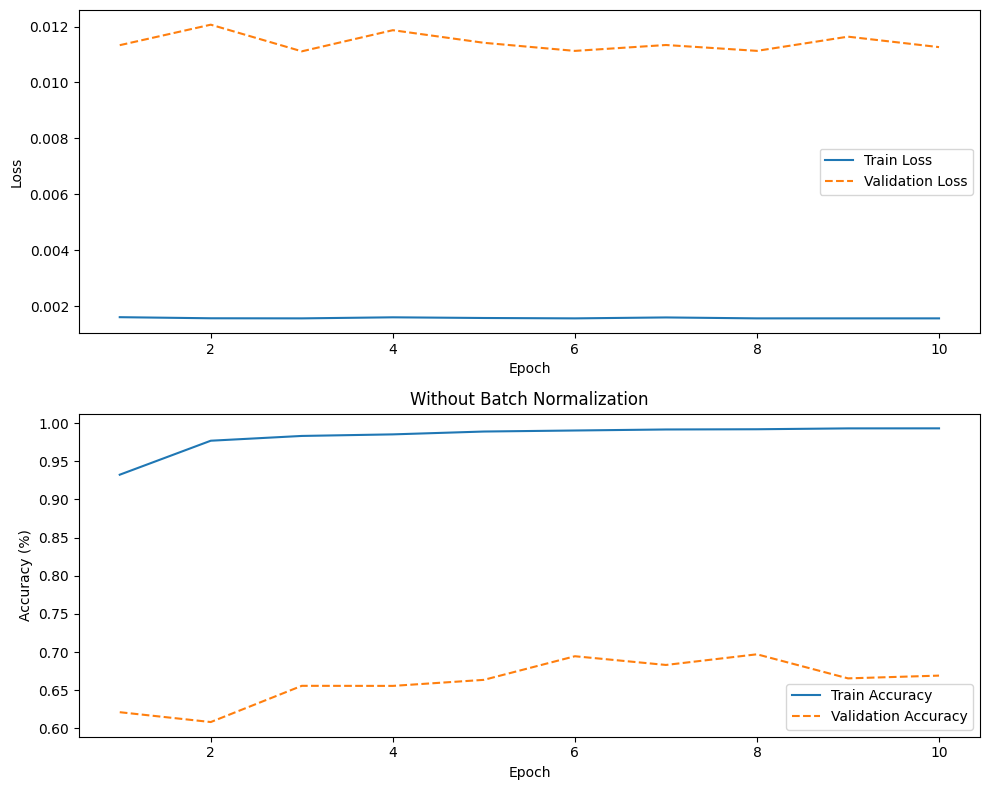

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

ax1.plot(range(1, num_epochs+1), train_loss_wobn_np, label='Train Loss')
ax1.plot(range(1, num_epochs+1), val_loss_wobn_np, label='Validation Loss', linestyle='dashed')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(range(1, num_epochs+1), train_acc_wobn_np, label='Train Accuracy')
ax2.plot(range(1, num_epochs+1), val_acc_wobn_np, label='Validation Accuracy', linestyle='dashed')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()

plt.title('Without Batch Normalization')
plt.tight_layout()
plt.show()